In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
# colab pro 더 빠른 GPU 사용
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Nov 18 07:59:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |  16251MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [28]:
# colab pro 추가 메모리
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [6]:
! pip install transformers
! pip install pytorch-lightning
! pip install torchmetrics
! pip install torchtext
! pip install lightning-flash
! pip install lightning-flash[image]

     |████████████████████████████████| 3.1 MB 7.5 MB/s 
     |████████████████████████████████| 895 kB 87.2 MB/s 
     |████████████████████████████████| 59 kB 8.1 MB/s 
     |████████████████████████████████| 596 kB 90.0 MB/s 
     |████████████████████████████████| 3.3 MB 59.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.0 MB 8.0 MB/s 
     |████████████████████████████████| 829 kB 71.8 MB/s 
     |████████████████████████████████| 132 kB 58.7 MB/s 
     |████████████████████████████████| 329 kB 77.6 MB/s 
     |████████████████████████████████| 1.1 MB 72.3 MB/s 
     |████████████████████████████████| 160 kB 94.3 MB/s 
     |████████████████████████████████| 271 kB 76.3 MB/s 
     |████████████████████████████████| 192 kB 81.4 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=9e4c3908641845

In [39]:
from transformers import BigBirdPegasusForConditionalGeneration, AutoTokenizer, AdamW
import json
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl 
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import gc

In [8]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

In [9]:
pl.seed_everything(42) # 학습한 모델을 재생산(Reproduction)하기 위해 사용.

Global seed set to 42


42

#### 데이터 불러오기

In [10]:
from google.cloud import storage

train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Aiffel_Hackathon/Data/Training_Data_Clean.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Aiffel_Hackathon/Data/Test_Data_Clean.csv')

In [11]:
train_df.head()

,Unnamed: 0,Original_Filename_x,Gold_Filename,Document,Full_Text,Summary_Text
0,0,15786_819157_2,15786_819156_1,15786,6 chief executive officer’s review the berong...,3 chairman’s statement in the 18 months since...
1,1,15783_819108_2,15783_819107_1,15783,chief executive officer’s statement the beron...,chairman s statement it has always been your ...
2,2,15782_819091_2,15782_819090_1,15782,chief executive officer’s statement the compa...,chairman’s statement the celestial ipilan ore...
3,3,15787_819176_2,15787_819175_1,15787,page 6 toledo mining corporation plc annual r...,page 5 i should like to begin my message with...
4,4,15816_820156_2,15816_820155_1,15816,3 chief executive’s statement tomkins plc rep...,2 tomkins plc report accounts 2003 chairman’s...


In [12]:
train_df = train_df[['Full_Text', "Summary_Text"]]
train_df.head(2)

,Full_Text,Summary_Text
0,6 chief executive officer’s review the berong...,3 chairman’s statement in the 18 months since...
1,chief executive officer’s statement the beron...,chairman s statement it has always been your ...


In [13]:
test_df = test_df[['Full_Text', 'Summary_Text']]
test_df.head(2)

,Full_Text,Summary_Text
0,25695 19 march 2018 3 29 pm proof 7 02 s . c ...,25695 19 march 2018 3 29 pm proof 7 a . c . q...
1,10 staffline group plc annual report 2017 chi...,6 staffline group plc annual report 2017 a ye...


In [14]:
train_df, val_df = train_test_split(train_df, test_size=0.2)
train_df.shape, val_df.shape

((1926, 2), (482, 2))

In [43]:
test_df.shape

(280, 2)

#### 데이터셋 만들기 

In [44]:
class FinancialSummaryDataset(Dataset):

  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: AutoTokenizer,
    text_max_token_len: int = 2048,
    summary_max_token_len: int = 500
  ):
    
    self.tokenizer = tokenizer
    self.data = data
    self.text_max_token_len = text_max_token_len
    self.summary_max_token_len = summary_max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    text = data_row["Full_Text"] 

    text_encoding = tokenizer(
      text,
      max_length=self.text_max_token_len,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      add_special_tokens=True,
      return_tensors="pt"
    )
  
    summary_encoding = tokenizer(
      data_row["Summary_Text"], 
      max_length=self.summary_max_token_len, # summary max token len
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      add_special_tokens=True,
      return_tensors="pt"
    )

    labels = summary_encoding["input_ids"] # 사용할 실제 레이블을 생성. tokenizer의 입력 id를 인코딩 
    labels[labels == 0] = -100 # idf가 0인 패딩 토큰을 -100으로 바꿔줍니다. 텍스트 생성에 필요한 올바른 레이블이 있는지 확인합니다.

    return dict(
      text=text,
      summary=data_row["Summary_Text"], 
      text_input_ids=text_encoding["input_ids"].flatten(), 
      text_attention_mask=text_encoding["attention_mask"].flatten(),
      labels=labels.flatten(),
      labels_attention_mask=summary_encoding["attention_mask"].flatten()
    )

In [45]:
class FinancialSummaryDataModule(pl.LightningDataModule):

  def __init__(
      self,
      train_df : pd.DataFrame,
      val_df : pd.DataFrame,
      test_df : pd.DataFrame,
      tokenizer: AutoTokenizer,
      batch_size : int = 1,
      text_max_token_len : int = 2048,
      summary_max_token_len : int = 500
  ):

    super().__init__()

    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.batch_size = batch_size
    self.tokenizer = tokenizer
    self.text_max_token_len = text_max_token_len
    self.summary_max_token_len = summary_max_token_len

  def setup(self, stage=None):
    self.train_dataset = FinancialSummaryDataset(
      self.train_df,
      self.tokenizer,
      self.text_max_token_len,
      self.summary_max_token_len
    )
    
    self.val_dataset = FinancialSummaryDataset(
        self.val_df,
        self.tokenizer,
        self.text_max_token_len,
        self.summary_max_token_len
    )

    self.test_dataset = FinancialSummaryDataset(
      self.test_df,
      self.tokenizer,
      self.text_max_token_len,
      self.summary_max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      # num_workers=4 # 주석처리 풀고 2에서 4로 바꿈
      )
    
  def val_dataloader(self):
    return DataLoader(
      self.val_dataset,  
      batch_size=self.batch_size,
      shuffle=False,
      # num_workers=4 # 주석처리 풀고 2에서 4로 바꿈
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      shuffle=False
      #num_workers=2 
    )

In [46]:
MODEL_NAME = "google/bigbird-pegasus-large-bigpatent"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

#### 토큰 수 확인

In [47]:
text_token_counts, summary_token_counts = [], []

for _, row in train_df.iterrows():
  text_token_count = len(tokenizer.encode(row["Full_Text"]))
  text_token_counts.append(text_token_count)

  summary_token_count = len(tokenizer.encode(row["Summary_Text"]))
  summary_token_counts.append(summary_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (4551 > 4096). Running this sequence through the model will result in indexing errors


Text(0.5, 1.0, 'text token counts')

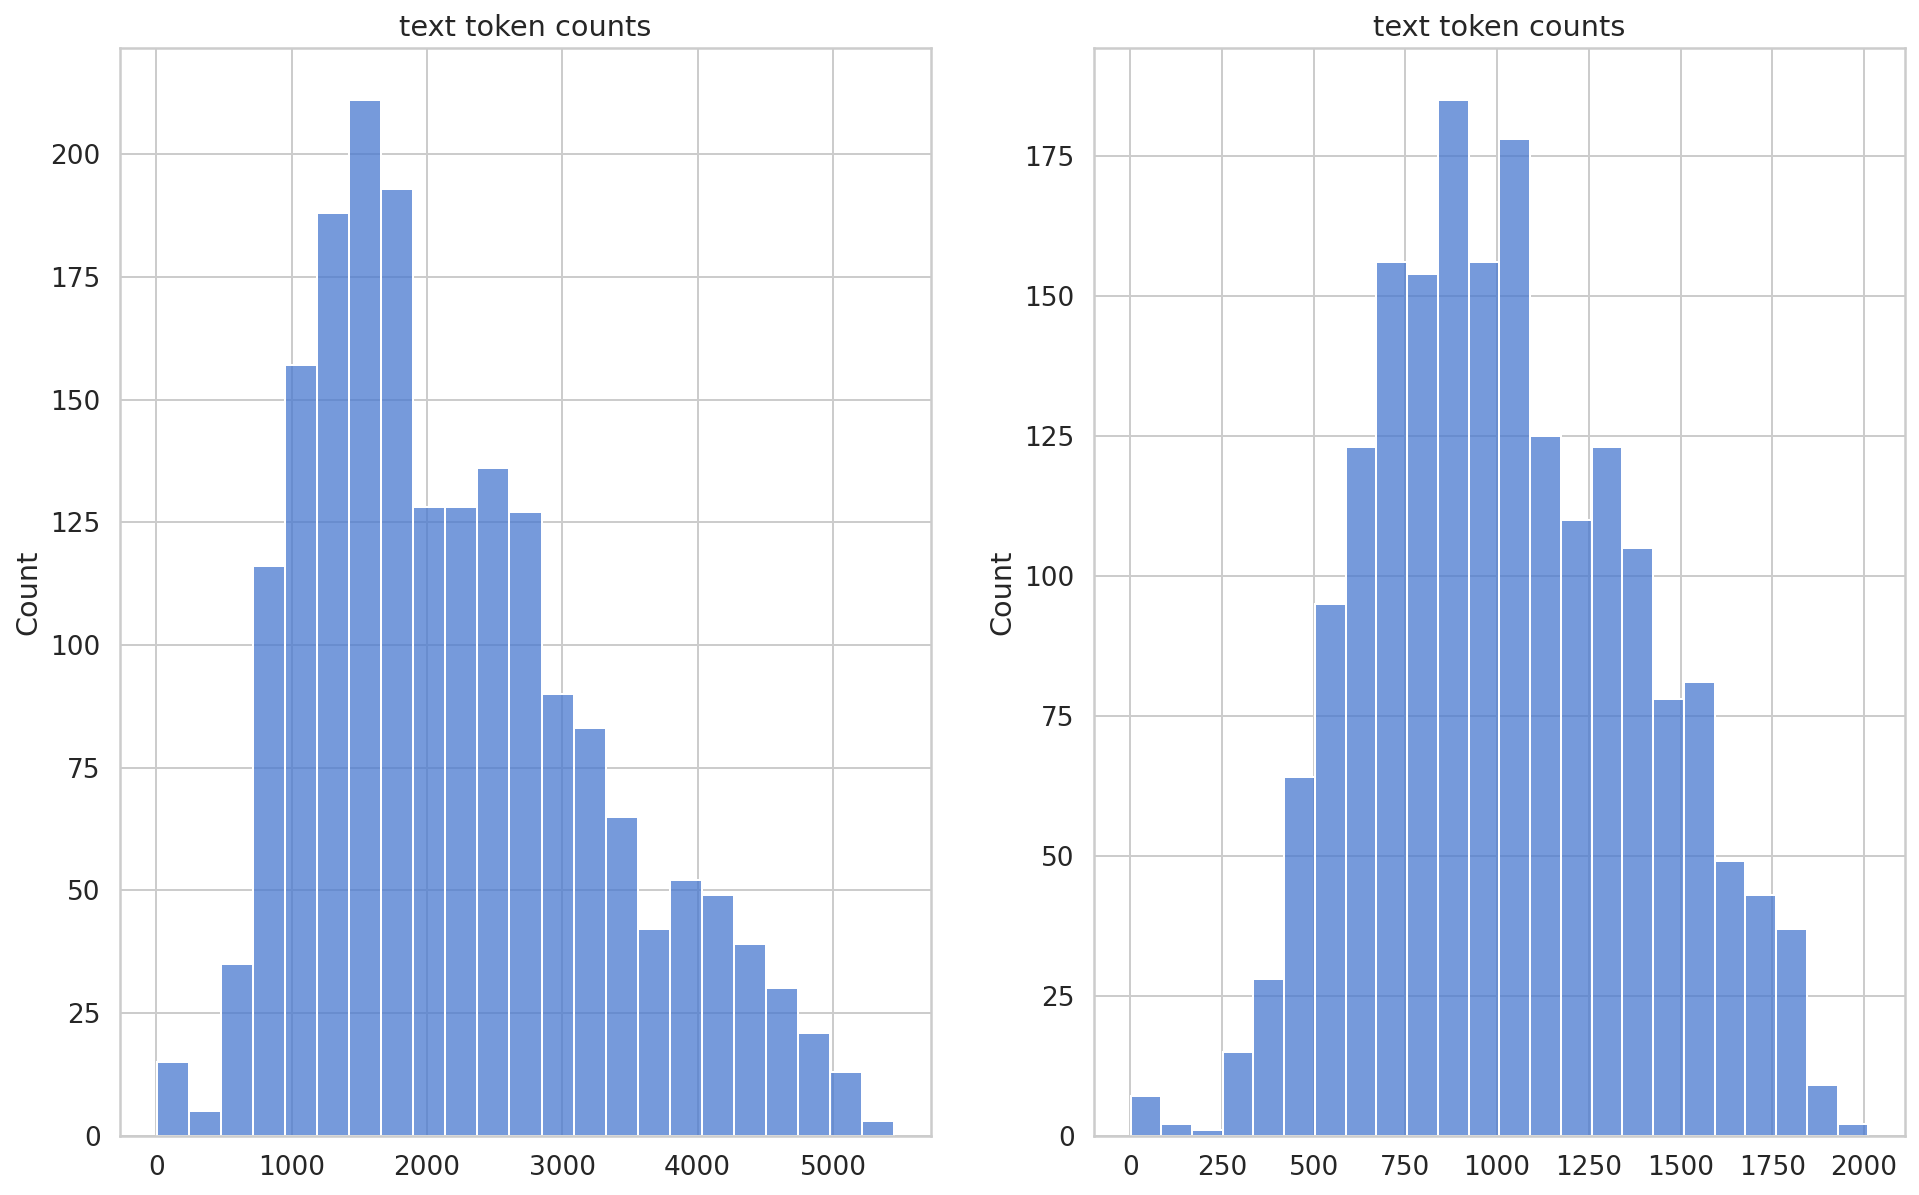

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.histplot(text_token_counts, ax=ax1)
ax1.set_title("text token counts")

sns.histplot(summary_token_counts, ax=ax2)
ax2.set_title("text token counts")

In [49]:
N_EPOCHS = 2
BATCH_SIZE = 1

data_module = FinancialSummaryDataModule(train_df, val_df, test_df, tokenizer, batch_size=BATCH_SIZE)

#### 모델 

In [50]:
class FinancialSummaryModel(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.model = BigBirdPegasusForConditionalGeneration.from_pretrained("google/bigbird-pegasus-large-bigpatent", return_dict=True)

  def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):

    output = self.model(
      input_ids,
      attention_mask=attention_mask,
      labels=labels,
      decoder_attention_mask=decoder_attention_mask
    )

    return output.loss, output.logits

  def training_step(self, batch, betch_idx_):
    input_ids = batch["text_input_ids"]
    attention_mask = batch["text_attention_mask"]
    labels = batch["labels"]
    labels_attention_mask = batch["labels_attention_mask"]

    loss, outputs = self(
      input_ids=input_ids,
      attention_mask=attention_mask,
      decoder_attention_mask=labels_attention_mask,
      labels=labels
    )

    self.log("train_loss", loss, prog_bar=True, logger=True)
    return loss

  def validation_step(self, batch, betch_idx_):
    input_ids = batch["text_input_ids"]
    attention_mask = batch["text_attention_mask"]
    labels = batch["labels"]
    labels_attention_mask = batch["labels_attention_mask"]

    loss, outputs = self(
      input_ids=input_ids,
      attention_mask=attention_mask,
      decoder_attention_mask=labels_attention_mask,
      labels=labels
    )

    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, betch_idx_):
    input_ids = batch["text_input_ids"]
    attention_mask = batch["text_attention_mask"]
    labels = batch["labels"]
    labels_attention_mask = batch["labels_attention_mask"]

    loss, outputs = self(
      input_ids=input_ids,
      attention_mask=attention_mask,
      decoder_attention_mask=labels_attention_mask,
      labels=labels
    )

    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def configure_optimizers(self):
    return AdamW(self.parameters(), lr=0.0001)

In [51]:
model = FinancialSummaryModel()

In [52]:
dirpath = "/content/drive/MyDrive/Colab Notebooks/Aiffel_Hackathon/BigBird"

checkpoint_callback = ModelCheckpoint(
    dirpath=dirpath,
    filename='{epoch}-{val_loss:.2f}-{other_metric:.2f}',
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="financial-summary")

trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback], 
    max_epochs=N_EPOCHS,
    gpus=-1,
    auto_select_gpus=True,
    progress_bar_refresh_rate=30
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [55]:
gc.collect()

499

In [59]:
trainer.fit(model, data_module)

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=e7e6030ab5d2e5bc524cad800486fa80dd953782b889e8be6292b6c84b1ebc73
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                                   | Params
-----------------------------------------------------------------
0 | model | BigBirdPegasusForConditionalGeneration | 576 M 
-----------------------------------------------------------------
576 M     Trainable params
0         Non-trainable params
576 M     Total params
2,307.568 Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/.shortcut-targets-by-id/1w4WyhAQ16CIFKNbtXntCgKMZoYxIpzws/Aiffel_Hackathon/BigBird exists and is not e

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/transformers/models/bigbird_pegasus/modeling_bigbird_pegasus.py:792: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  * num_indices_to_pick_from
Global seed set to 42
/usr/local/lib/python3.7/dist-pac

Training: 0it [00:00, ?it/s]

RuntimeError: ignored